# Introduction

This notebook is a collection of notes and resources for this work.


# Resources


These are extensive notes on process, open tasks, challenges, workarounds. 
The Python Data Science Handbook is abbreviated herein as PDSH.


## On using this notebook

This notebook is way down into the weeds. 
Eventually it will be broken into multiple chapters under Documentation.
I am using header size carefully so scroll or link on down until the header gets big again at
the next topic. To help here is a TOC.

* [Reducing Datasets](#Reducing-Datasets)
    * [One minute resampling](#One-minute-resampling)
* [Plotting](#Plotting)
    * [Making animations](#Making-animations)
* [Multimedia](#Multimedia)
    * [Images](#Images)
    * [Animations](#Animations)
    * [Sound clips](#Sound-clips)
* [XArray Datasets and DataArrays](XArray-Datasets-and-DataArrays)
* [Pandas Series and DataFrames](Pandas-Series-and-DataFrames)
* [Numpy ndarrays](#Numpy-ndarrays)
* [Time](#Time)
* [ipywidgets](#ipywidgets)
* [HoloView](#HoloView)
* [Binder](#Binder)

## Reducing Datasets

### Summary

We are working with extended multi-dimensional oceanography datasets. These are often in 
NetCDF format and must be sliced, diced, filtered, differentiated and plotted for comparison.
There is a lot to do. In order to carry the up-front visual message the very first notebook
covers Oregon Slope Base shallow profiler sensors; using a locally available dataset. The
reason for this is the data can "fit" inside a [GitHub repo](https://github.com/robfatland/ocean)
and the notebook can therefore
run in binder without any preparation beyond 
[clicking the binder badge](https://mybinder.org/v2/gh/robfatland/ocean/HEAD)
and waiting 
a couple minutes while the binder (sandbox) version of the repo loads. So in this section
let's cover how to do this sort of subsetting. The sensor sampling rate is often once or twice
per second so a big part of this is down-sampling to one sample per minute. 


### Oregon Slope Base shallow profiler sensor abbreviation table 


- `ctdpf` 3 observables: salinity, temperature and dissolved oxygen against depth
- `pCO2`  ...carbonate chemistry: No data at this time
- `nutnr` 1 observable: nitrate (used on noon/midnight ascent)
- `phsen` 1 observable: pH (used on noon/midnight descent with stops)
- `flort` 3 observables: Fluorometer for chlorophyll concentration, cdom fluorescence, backscatter (triplet)
- `spkir` 7 observables: spectral irradiance; down-welling
- `parad` 1 observable: photosynthetically available radiation, sunlight available for photosynthesis

<BR>

- need an entry for spectrophotometer; which is treated a little differently

### Prefatory note: 'Super slow' resampling problem


* A Dataset operation that should take seconds takes *hours*
    * Spectrophotometer has 86 channels: 'One observation with 86 values'
    * Associated: Depth and time per each observation; suppose 14k observations per profile 
    * Result: Multiply-indexed data.
    * `time` is the default dimension (superseding `obs`) but we want sort by depth
        * Depth bins contain many observations
    * Resample 200m at 0.25m bins: 86 x 14000 data values to average into 86 x 800 bins
        * Task takes hours

The solution comes from page 137 of PDSH, on **Rearranging Multi-Indices**
and **Sorted and unsorted indices**; quoting: 

> ***Rearranging Multi-indices***<BR>
One of the keys to working with multiply indexed data is knowing how to effectively transform the data. 
There are a number of operations that will preserve all the information in the dataset, but rearrange 
it for the purposes of various computations. [...] There are many [ways] to finely control the rearrangement
of data between heirarchical indices and columns.
    
> ***Sorted and unsorted indices***<BR>
Earlier, we briefly mentioned a caveat, but we should emphasize it more here. 
*Many of the `MultiIndex`slicing operations will fail if the index is not sorted.*

### One minute resampling

We want the repository to contain a certain amount of downsampled data. The time window
is January 2019 to start with. The sample rate is one sample per minute. The ascent rate 
is about 180 meters in about 45 minutes or roughly 4 meters per minute. This is adequate to see basic
water column structure through the sensor 'lens'. 


* 86400 seconds per day, 1440 minutes per day, about 45k samples per January at 1Min intervals

We have two mechanisms available in `xarray Datasets`: `.sel(time=slice(dt64-A, dt64-B))`
and `ds_1min = ds.resample(time='1Min').mean()`. Also we can use `.std()` if we wish to
expand into standard deviation signals. 


There is a problem, however: The `xarray .resample()` method can hang. This may be a time-sort
issue where the prior `.sel()` time slice is not understood as a monotonic time dimension.
Whatever the cause there is a work-around using `pandas Dataframes`. Start by loading the 
full-resolution data from a data drive: 


```
ctd_source = '/data/rca/ctd/'
ctd_data = 'osb_sp_ctdpf_2019.nc'
ds_CTD = xr.open_dataset(ctd_source + ctd_data)
ds_CTD

time_jan1 = dt64('2019-01-01')
time_feb1 = dt64('2019-02-01')
ds_CTD_jan2019 = ds_CTD.sel(time=slice(time_jan1, time_feb1))
ds_CTD_jan2019
```

This .resample() code hangs:


```
# forever fail
# ds_CTD_jan2019_1Min = ds_CTD_time_slice.sel(time=slice(time_jan1, \
#                                                        time_feb1)).resample(time='1Min').mean()
# ds_CTD_jan2019_1Min
```

Here is the pandas dataframe workaround:


```
df   = ds_CTD_jan2019.to_dataframe().resample("1Min").mean()
vals = [xr.DataArray(data=df[c], dims=['time'], coords={'time':df.index}, attrs=ds_CTD_jan2019[c].attrs) for c in df.columns]
ds_CTD_jan2019_1Min = xr.Dataset(dict(zip(df.columns, vals)), attrs=ds_CTD_jan2019.attrs)
ds_CTD_jan2019_1Min
```


This writes out the down-sampled data as a new NetCDF file. Notice it is a "local" data directory.


```
osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ds_CTD_jan2019_1Min.to_netcdf(osb_ctd_nc_file)
```

This loads the resulting data; so this is the starting point of the data exploration code: 


```
ds_CTD = xr.open_dataset(osb_ctd_nc_file)
ds_CTD
```

Flourometry code redux: For OSB shallow profiler triplet, to 1Min samples, JAN 2019


```
ds_Fluorometer = xr.open_dataset('/data/rca/fluorescence/osb_sp_flort_2019.nc')
time_jan1, time_feb1 = dt64('2019-01-01'), dt64('2019-02-01')
ds_Fluor_jan2019 = ds_Fluorometer.sel(time=slice(time_jan1, time_feb1))
df               = ds_Fluor_jan2019.to_dataframe().resample("1Min").mean()
vals             = [xr.DataArray(data=df[c], dims=['time'], coords={'time':df.index}, \
                    attrs=ds_Fluor_jan2019[c].attrs) for c in df.columns]
xr.Dataset(dict(zip(df.columns, vals)), \
           attrs=ds_Fluor_jan2019.attrs).to_netcdf('./data/rca/fluorescence/osb_sp_fluor_jan2019.nc')
```

Spectral irradiance stopgap version: Break out by spectrum (should be dimension of just one file).

```
spectral_irradiance_source = '/data/rca/irradiance/'
spectral_irradiance_data = 'osb_sp_spkir_2019.nc'
ds_spectral_irradiance = xr.open_dataset(spectral_irradiance_source + spectral_irradiance_data)
ds_spectral_irradiance
time_jan1, time_feb1 = dt64('2019-01-01'), dt64('2019-02-01')
ds_Irr_jan2019 = ds_spectral_irradiance.sel(time=slice(time_jan1, time_feb1))
df = [ds_Irr_jan2019.sel(spectra=s).to_dataframe().resample("1Min").mean() for s in ds_Irr_jan2019.spectra]
r = [xr.Dataset(dict(zip(q.columns, 
                         [xr.DataArray(data=q[c], dims=['time'], coords={'time':q.index}, \
                                       attrs=ds_Irr_jan2019[c].attrs) for c in q.columns] \
                    )   ), 
                attrs=ds_Irr_jan2019.attrs)
    for q in df]
for i in range(7): r[i].to_netcdf('./data/rca/irradiance/osb_sp_irr_spec' + str(i) + '.nc')
```


Spectral irradiance related skeleton code showing use of `.isel(spectra=3)`: 


```
ds = ds_spkir.sel(time=slice(time0, time1))
da_depth = ds.int_ctd_pressure.resample(time='1Min').mean()
dsbar = ds.resample(time='1Min').mean()
dsstd = ds.resample(time='1Min').std()
dsbar.spkir_downwelling_vector.isel(spectra=3).plot()


plot_base_dimension = 4
indices = [0, 1, 2, 3, 4, 5, 6]
n_indices = len(indices)
da_si, da_st = [], []


for idx in indices: 
    da_si.append(dsbar.spkir_downwelling_vector.isel(spectra=idx))
    da_st.append(dsstd.spkir_downwelling_vector.isel(spectra=idx))


fig, axs = plt.subplots(n_indices, 2, figsize=(4*plot_base_dimension, plot_base_dimension*n_indices), /
           sharey=True, tight_layout=True)


axs[0][0].scatter(da_si[0], da_depth, marker=',', s=1., color='k') 
axs[0][0].set(ylim = (200., 0.), xlim = (-.03, .03), title='spectral irradiance averaged')
axs[0][1].scatter(da_st[0], da_depth, marker=',', s=1., color='r')
axs[0][1].set(ylim = (200., 0.), xlim = (0., .002), title='standard deviation')


for i in range(1, n_indices):
    axs[i][0].scatter(da_si[i], da_depth, marker=',', s=1., color='k')
    axs[i][0].set(ylim = (200., 0.), xlim = (-.03, .03))
    axs[i][1].scatter(da_st[i], da_depth, marker=',', s=1., color='r')
    axs[i][1].set(ylim = (200., 0.), xlim = (0., .002))
```

Code for PAR

```
par_source = '/data/rca/par/'
par_data = 'osb_sp_parad_2019.nc'
ds_par = xr.open_dataset(par_source + par_data)
time_jan1 = dt64('2019-01-01')
time_feb1 = dt64('2019-02-01')
ds_par_jan2019 = ds_par.sel(time=slice(time_jan1, time_feb1))
df   = ds_par_jan2019.to_dataframe().resample("1Min").mean()
vals = [xr.DataArray(data=df[c], dims=['time'], coords={'time':df.index}, attrs=ds_par_jan2019[c].attrs) for c in df.columns]
ds_par_jan2019_1Min = xr.Dataset(dict(zip(df.columns, vals)), attrs=ds_par_jan2019.attrs)
osb_par_nc_file = "./data/rca/par/osb_sp_par_jan2019.nc"
ds_par_jan2019_1Min.to_netcdf(osb_par_nc_file)
```

PAR view: during shallow profiler rise/fall sequences

```
t0, t1 = '2019-07-17T13', '2019-07-18T05'
t0, t1 = '2019-07-17T18:40', '2019-07-17T19:40'
t0, t1 = '2019-07-17T21', '2019-07-17T23:00'        # These are the nitrate profiles
t0, t1 = '2019-07-18T21', '2019-07-18T23:00'
t0, t1 = '2019-07-19T21', '2019-07-19T23:00'
t0, t1 = '2019-07-17T18:40', '2019-07-17T19:40'     # These are the profiles prior to nitrate
t0, t1 = '2019-07-18T18:40', '2019-07-18T19:40'
t0, t1 = '2019-07-19T18:40', '2019-07-19T19:40'
da = ds_parad.sel(time=slice(t0, t1)).par_counts_output
p=da.plot.line(marker='o', figsize = (14,8), markersize=1, yincrease = True)
```

Staged 'nitrate' profile compared with 'normal' profile

```
t0, t1 = '2019-07-19T20:30', '2019-07-19T23:50'               # USE THIS!! This is a good nitrate profile time bracket
t0, t1 = '2019-07-19T18:40', '2019-07-19T19:40'
da = ds_parad.sel(time=slice(t0, t1)).int_ctd_pressure
p=da.plot.line(marker='o', figsize = (14,8), markersize=1, yincrease = False)
```

## Plotting 

### Summary

Here I use [**`pyplot`**](https://plotly.com/python/), the Python graphing library usually imported as `plt`. 
Plotly is part of the matplotlib package. It is super confusing unless one has
an extensive block of time to study it with care. In particular
we need to be experts at "drawing charts" both with `.scatter` and `.plot`. Furthermore
there is a quick-and-dirty `.plot` within XArray Datasets that can save time during
development by giving a quick sanity check. In this section I will cover the basics 
of charting data in this context.

### To investigate

* Jake talks about Seaborn in PDSH; worth a look

### Diving in

### Sharing an axis


Suppose a figure has an axis or a list of axes. These have a method `.twiny()` which creates
a copy that can have its own x-axis stipulated. Same thing for `.twinx()`. This is demonstrated
in the **Ocean 01 D Photic Zone Reduction** notebook. It risks cluttering the chart with the idea
of condensing information.

### Grid of charts

This is example code for time-series data. It sets up a 3 x 3 grid of charts. These are matched to a 2-D set of
axes (the 'a' variable) with both the scatter() and plot() constructs.

```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))    # first 3 is vertical count, second 3 is horizontal count

plt.rcParams.update({'font.size': 10})

a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

### Making animations

## Multimedia

<BR>
<img src="./images/fauna/dubious.png" style="float: left;" alt="dubious person trying to eat kelp" width="100"/>
<div style="clear: left">
<BR>

This png file of a child dubiously eating kelp illustrates transparent pixels. 
There are lots of free/native apps on any given laptop that do this. 
    
    
### Summary

We want to include (in order of importance) images, animations of data and sound clips. The above image,
incidentally, includes transparent pixels: Done on a PC using Paint 3D, where the process is a bit convoluted. 

### Images

The cleanest presentation for static images in my experience so far is to use HTML in a 
markdown cell. It looks as follows where `<BR>` is a line break giving some spacing. Note
the relative path.

```
<BR>
<img src="./images/vessels/revelle.jpg" style="float: left;" alt="ship and iceberg photo" width="900"/>
<div style="clear: left">
<BR>
```

It is possible to include images in Python cells using PIL but it was more of a chore.


### Animations
    
Once an mp4 file is written to the file system playback is simple: Import `Video` from `IPython.display`
and play the file back using `Video` setting the `embed` flag True.


```
from IPython.display import Video
Video("./<some_animation>.mp4", embed=True)
```

Alternative to `, embed=True`: Turn on the inline back-end using `%matplotlib inline` line magic

    
#### YouTube video playback
    
```
from IPython.display import YouTubeVideo
YouTubeVideo('sjfsUzECqK0')
```
    
### Sound clips
    
```
from IPython.display import Audio
Audio("<audiofile>.mp3")
```

## XArray Datasets and DataArrays

### Summary

There are a million little details about working with XArray Datasets, DataArrays, numpy arrays, pandas DataFrames,
pandas arrays... let's begin! The main idea is that a **DataArray** is an object containing, in the spirit of 
the game, one sort of data; and a **Dataset** is a collection of associated **DataArray**s. 


### XArray ***DataSet*** basics

**Datasets** abbreviated `ds` have four components { dimensions, coordinates, data variables, 
attributes }.


The matter of a name in relation to a **DataArray** is worth describing so to do. 


```
ds.variables                                  # to do detail on what this is in relation to 'four'

ds.data_vars                                  # to do elaborate 'dict-like object'
for dv in ds.data_vars: print(dv)
    
choice = 2
this_data_var = list(ds.data_vars)[choice]
print(this_data_var)

ds.coords
ds.dims
ds.attrs
```

#### Load via `open_mfdataset()` with dimension swap from `obs` to `time`

The asterisk (e.g. 'nutnr_a_sample*') is wildcard construction to treat multiple files as one Dataset. 
The key feature here is that ds is now monolithic, not fragmented like the source files. 

```
strRoot = 'rca/2019/depl*'
strSite = 'SBPS*'
strPlatform = 'SF*'

def lass_preprocessor(fds): return fds.swap_dims({'obs':'time'})
ds = xr.open_mfdataset(data_dir + strRoot + strSite + strPlatform + 'nutnr_a_sample*.nc', 
                       preprocess = lass_preprocessor, 
                       concat_dim='time', combine='by_coords')
ds
```

#### Obstacle: Getting information out of a Dataset

There is a sort of comprehension / approach that I have found hard to internalize.
With numpy ndarrays, XArray Datasets, etcetera there is this "how do I get at it?"
problem. As this documentation evolves I will try and articulate the most helpful
mindset. The starting point is that Datasets are built as collections of DataArrays; 
and these have an indexing protocol the merges with a method protocol (`sel`, `merge`
and so on) where the end-result code that does what I want is inevitably very 
elegant. So it is a process of learning that elegant sub-language...


##### Example: Get a time dimension value as `datetime64` from a Dataset using an index

Supposing the linked coordinate / dimension is `time`. This can be referenced using 
`dt.time[i]` but it will come out as a 1-D 1-element DataArray. Therefore it is 
necessary to do more; as in this example where we select the `.data` field and cast
the resulting ndarray (with one element) as a `dt64`. This works but feels 
incomplete; maybe unnecessarily clunky.

```dt64(ds.time[i].data)```

### XArray ***DataArray*** name and length


```
sensor_t.name

len(sensor_t)
len(sensor_t.time)           # gives same result
```

What is the name of the controlling dimension?

```
if sensor_t.dims[0] == 'time': print('time is dimension zero')
```

Equivalent; but the second version permits reference by "discoverable" string.


```
sensor_t = ds_CTD_time_slice.seawater_temperature
sensor_t = ds_CTD_time_slice['seawater_temperature']
```

#### Plotting with scaling and offsetting

Suppose I wish to shift some data left to contrast it with some other data (where they would clobber one another)...

```
sensor_t + 0.4
```

Suppose I wish to scale some data in a chart to make it easier to interpret given a fixed axis range

```
sensor_t * 10.               # this fails by trying to make ten copies of the array

np.ones(71)*3.*smooth_t      # this works by creating an inner product
```

### XArray challenges
    
    
As an example of the challenge of learning `XArray`: The reduction of this data to binned profiles
requires a non-trivial workflow. A naive approach can result in a calculation that should take 
a seconds run for hours. (A key idea of this workflow -- the sortby() step -- is found on page 137 of **PDSH**.)
    
    
- `swap_dims()` to substitute `pressure` for `time` as the ordinate dimension
- `sortby()` to make the `pressure` dimension monotonic
- Create a pressure-bin array to guide the subsequent data reduction
- `groupby_bins()` together with `mean()` to reduce the data to a 0.25 meter quantized profile
- use `transpose()` to re-order wavelength and pressure, making the resulting `DataArray` simpler to plot
- accumulate these results by day as a list of `DataArrays`
- From this list create an `XArray Dataset`
- Write this to a new NetCDF file


## Pandas Series and DataFrames

### Summary

### DataFrames

DataFrames:

* constructor takes `data=<ndarray>` and both `index` and `columns` arguments... 
    * ...2 dimensions only: higher dimensions and they say 'use XArray'
    * ...and switching required a `.T` transpose
* indexing by column and row header values, separated as in `[column_header][row_header]`
    * as this reverses order from ndarrays: Better confirm... seems to be the case
    * skip index/columns: defaults to integers.
 
Below this section we go into n-dimensional arrays in Numpy, the *ndarray*. Here we take this 
for granted and look at the relationship with DataFrames.

In [2]:
###################
#
# A micro study of ndarray to DataFrame translation
#
###################

import numpy as np
import pandas as pd

# Here is an ndarray construction from a built list of lists (not used in what follows): 
# arr = np.array([range(i, i+5) for i in [2, 4, 6]])                                       # the range() runs across columns; 2 4 6 are rows

# ndarray construction: Notice all list elements are of the same type (strings)
arr = np.array([['l','i','s','t','1'],['s','c','n','d','2'],['t','h','r','d', '3']])

print('\nndarray from a list of lists (notice no comma delimiter):\n\n', arr, '\n\nand indexing comparison: first [0][2] then [2][0]:', arr[0][2], arr[2][0]) 
print('\nand tuplesque indexing [0, 2] or [2, 0] equivalently gives:', arr[0,2], arr[2,0])
print('\nSo ndarrays index [slow][fast] equivalent to [row][column]\n\n\nMoving on to DataFrames:\n\n')

rowlist=["2row", "4row", "6row"]
columnlist = ["col_a", "col_b", "col_c", "col_d", "col_e"]
df = pd.DataFrame(data=arr, index=rowlist, columns=columnlist)

print(df, '\n\nis a DataFrame from the ndarray; so now index ["col_c"]["6row"]:', df['col_c']['6row'])

df = pd.DataFrame(data=arr.T, index=columnlist, columns=rowlist)

print('\nHere is a Dataframe from a transpose of the ndarray\n\n', df, '\n\nindexing 2row then col_e:', df['2row']['col_e'])
print('\nSo the column of a DataFrame is indexed first, then the row: Reverses the sense of the 2D ndarray.\n')
print('Now skipping the "index="" argument so the row labels default to integers:\n')

df = pd.DataFrame(data=arr, columns=columnlist)

print(df, '\n\n...so now indexing ["col_d"][0]:', df['col_d'][0], '\n')

df = pd.DataFrame(data=arr, index=rowlist)

print(df, '\n\nhaving done it the other way: used index= but not columns=. Here is element [0]["4row"]:', df[0]['4row'])


print('\n\nStarting from an XArray Dataset and using .to_dataframe() we arrive at a 2D structure.\n')
print('For example: df = ds_CTD.seawater_pressure.to_dataframe()')
print(' ')
print('The problem is that the resulting dataframe may not be indexed (row sense) using integers. A fix')
print('is necessary to override the index and columns attributes of the dataframe, as in:')
print(' ')
print('             df.index=range(len(df))')
print('             df.columns=range(1)')
print(' ')
print('results in a dataframe that one can index with integers [0] for column first then [n] for row.')
print('This example came from the profile time series analysis to get ascent start times and so on.')
print('The problem is it is a case of too much machinery. It is far simpler to use a pandas Series.')


ndarray from a list of lists (notice no comma delimiter):

 [['l' 'i' 's' 't' '1']
 ['s' 'c' 'n' 'd' '2']
 ['t' 'h' 'r' 'd' '3']] 

and indexing comparison: first [0][2] then [2][0]: s t

and tuplesque indexing [0, 2] or [2, 0] equivalently gives: s t

So ndarrays index [slow][fast] equivalent to [row][column]


Moving on to DataFrames:


     col_a col_b col_c col_d col_e
2row     l     i     s     t     1
4row     s     c     n     d     2
6row     t     h     r     d     3 

is a DataFrame from the ndarray; so now index ["col_c"]["6row"]: r

Here is a Dataframe from a transpose of the ndarray

       2row 4row 6row
col_a    l    s    t
col_b    i    c    h
col_c    s    n    r
col_d    t    d    d
col_e    1    2    3 

indexing 2row then col_e: 1

So the column of a DataFrame is indexed first, then the row: Reverses the sense of the 2D ndarray.

Now skipping the "index="" argument so the row labels default to integers:

  col_a col_b col_c col_d col_e
0     l     i     s     t    

/home/ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Numpy ndarrays
### Summary

### Diving in 

numpy ndarrays 

* do not have row and column headers; whereas pandas DataFrames do have typed headers
* indexing has an equivalence of `[2][0]` to `[2,0]` 
    * The latter (with comma) is the presented way in PDSH
    * This duality does not work for DataFrames
* has row-then-column index order...
    * ....with three rows in `[['l','i','s','t','1'],['s','c','n','d','2'],['t','h','r','d','3']]` 
* has slice by dimension as `start:stop:step` by default `0, len (this dimension), 1` 
    * ...exception: when `step` is negative `start` and `stop` are reversed
    * ...multi-dimensional slices separated by commas
    


## Time
### Summary

There is time in association with data (when a sample was recorded) and time in association with
code development (how long did this cell take to run?) Let's look at both.


### Sample timing

See PDSH-189. There are two time mechanisms in play: Python's built-in `datetime` and an improvement called
`datetime64` from **numpy** that enables *arrays* of dates, i.e. time series. 


Consider these two ways of stipulating time slice arguments for `.sel()` applied to a DataSet.
First:  Use a datetime64 with precision to minutes (or finer).
Second: Pass strings that are interpreted as days, inclusive. In pseudo-code: 

```
if do_precision:  
   t0 = dt64('2019-06-01T00:00')
   t1 = dt64('2019-06-01T05:20')
   dss = ds.sel(time=slice(t0, t1))   
else:
    day1 = '24'
    day2 = '27'              # will be 'day 27 inclusive' giving four days of results
    dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))

len(dss.time)
```

### Execution timing

Time of execution in seconds: 

```
from time import time

toc = time()
for i in range(12): j = i + 1
tic = time()
print(tic - toc)

7.82012939453125e-05
```


## ipywidgets
### Summary

## Holoview
### Summary

## Process these notes


### Open issues

* Does re-sample to (say) minutes over a time where data are missing create skips? Or nans? 
* What does merge() do? 

```
ds = ds.merge(ds_flort)
```

* Order: `.merge()` then `.resample()` with `mean()`; or vice versa? (existing code is vice-versa)
    * This approach does resampling prior to merge but was taking way too long

```
ds = ds_flort.copy()
ds = ds.reset_coords('seawater_pressure')        # converts the coordinate to a data variable
ds_mean = ds.resample(time='1Min').mean()
ds_std  = ds.resample(time='1Min').std()
```

* How to copy a dataset, move a coordinate to a data variable

```
ds = ds_ctdpf.copy()
ds = ds.reset_coords('seawater_pressure')        # converts the coordinate to a data variable
```

* Standard deviation method

```
ds_std  = ds.resample(time='1Min').std()
```

* Load R/M Dataset ctdpf + flort
    * Some data are noisier towards the surface, some are ridiculously noisy. 
    * Idea: Filter on standard deviation, threshold:
        * Filter leaves a signal of interest? 
    * Fluorometer is particularly troublesome. 


* Depth profiles reduce to simple metrics
    * profile start, peak, end times
    * platform residence: start and end times (from profile times)
    * (smoothed) chlorophyll derivative, curvature, rate of curvature
    * Similarly salinity seems to go through a consistent double-zero in rate of curvature
    * intersection depth as used in TDR; for example for temperature or salinity
        * extrapolate smoothed pressure by backing off the derivative change
        * extrapolate platform, intersect
    * time of day / sun angle
    * local time
    * rate of ascent verify; 3m / minute?

## Spectrophotometer (SP) and Nitrate


### Summary

The SP runs on ascent only, at about 3.7 samples per second. Compare nitrate that also runs 
on ascent only at about 3 samples per minute. Nitrate data is fairly straightforward; SP 
data is chaotic/messy. The objective is to reduce the SP to something interpretable.


### Deconstructing data: process pattern


- `ds = xr.open_dataset(fnm)` 
    - Data dispersed across files: Variant + wildcard: `ds = xr.open_mfdataset('data_with_*_.nc')`
- `obs` dimensional coordinate creates degeneracy over multiple files
    - Use `.swap_dims` to swap time for `obs`
- `ds.time[0].values, ds.time[-1].values` gives a timespan but nothing about duty cycles
    - 2019 spectrophotometer data at Oregon Slope Base: 86 channels, 7 million samples
    - ...leading to...
        - Only operates during midnight and noon ascent; at 3.7 samples per second
        - Optical absorbance and beam attenuation are the two data types
        - Data has frequent dropouts over calendar time
        - Data has spikes that tend to register across all 86 channels
        - Very poor documentation; even the SME report is cursory


### [`optaa`](https://oceanobservatories.org/instrument-class/optaa/)


SP **Oregon Slope Base** five years of monthly data availability.


<BR>
<img src="./images/spectrophotometer/osb_2019_sp_availability.png" style="float: left;" alt="drawing" width="1200"/>
<div style="clear: left"/>
<BR>
    
    
Courtesy the Interactive Oceans data portal. 
2019 is somewhat intermittent and stops in September.

* Instrument duty cycle
    * The SP on the Oregon Slope Base shallow profiler...
        * runs episodically, twice per day: midnight and noon profile ascents (*not* descent)
            * **First is 7:22 Zulu: midnight off the coast of Oregon**
        * RCA shallow profilers execute nine profiles per day from 200m to 5m nominal depths
        * Profile duration is time scale of an hour or two
        * Here one profile is treated as a water column snapshot 
            * The operative dimension is pressure/depth, not time
        * SP runs during *ascent*, nitrate measures on *descent*
    * In between profiles: The profiler or Science Pod (SCIP) is at rest on a platform at a depth of 200 meters
    * The ascent minimum depth is five meters but is typically more, varying with sea conditions
* SP are optical absorption (abbreviated **OA**), beam attenuation (abbreviated **BA**), time and pressure
    * Pressure in dbar and depth in meters are treated as equivalent
    * Instrument sampling rate is ~3.7 samples per second
    * Instrument records 86 spectral channels
        * Light wavelength is ~(400nm + channel number x 4nm)
        * Channel width is ~20nm so channels overlap
        * Signals shift with wavelength making it possible to stack profiles in a single chart
    * Channels 0, 83, 84 and 85 tend to give `nan` values (not usable) for both OA and BA
        * In this work we tend to use channels 2 through 82
    * Both OA and BA data are idiosyncratic
        * The midnight OA data are quantized in a peculiar manner; see charts below
        * The noon OA are *somewhat* quantized but have more reasonable / data-like structure
        * BA data are not fraught with the OA quantization issue
            * Both midnight and noon BA data include substantial noise
            * Variance is also apparent in BA data
            * This suggests filtering by depth bin and possibly discarding outliers
* Un-answered questions
    * Why are OA data different in midnight versus noon profiles? 
    * Are OA and BA typically combined into a turbidity value?
    * What wavelength ranges are of particular interest?
    * How do these signals compare with fluorometers, nitrate, CTD, pH, etcetera? 
        * The OOI site has a brief SME evaluation circa 2016 that does not illuminate actual data use cases
* References froom OOI
    * [Table of instruments / designators / locations](https://oceanobservatories.org/instrument-series/optaad/)
    * [Spectrophotometer page](https://oceanobservatories.org/instrument-class/optaa/)
    * [Subject Matter Expert evaluation](https://oceanobservatories.org/2016/07/successful-sme-evaluation-spectrophotometer-optaa/)
    * [Code](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/opt_functions.py)


Paraphrasing the Subject Matter Export evaluation (link above): 


> Dr. Boss (SME) verified 1.5 months of data (April-May 2015): Processing and plotting data using the raw data and vendor calibration files 
> from the AC-S, salinity and temperature from a collocated CTD data to correct absorption and attenuation median spectra and scattering, 
> and data from a collocated fluorometer to cross-check the chlorophyll and POC results.
> 
> Consistency between the sensors suggests that they did not foul during the deployment. Not only did his results show that accurate data 
> was being produced by all the sensors in question, but the AC-S (an extremely sensitive instrument normally deployed for very short periods
> of time) did not drift noticeably during the deployment period, a notable achievement.



From the [sheet on Optical Absorption (**OA**)](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00700_Data_Product_SPEC_OPTABSN_OOI.pdf):


> The primary instrument (OPTAA) is the WET Labs ac-s spectral absorption and attenuation meter. 
The instrument provides a 75 wavelength output from approximately 400–750 nm with approximately 
4 nm steps. Individual filter steps have a full-width half maximum response that
range between about 10 to 18 nm. 
>
> There are a total of 35 OPTAA instruments deployed
throughout the initial OOI construction and integrated into the Pioneer, Endurance, Regional and
Global arrays. They are deployed at fixed depths (near-surface, mid-water column and sea floor)
and installed on moored profilers.
>
> The ac-s performs concurrent measurements of the water attenuation and absorption 
(the latter called 'OPTABSN').
>
> OPTABSN is a L2 product in that computation requires the raw signals emanating from a properly
calibrated and configured instrument as well as water temperature (TEMPWAT) and practical
salinity (PRACSAL) derived from a co-located and synchronized CTD. 
>
> While small corrections
for salinity are available at visible wavelengths (< 700 nm), temperature and salinity corrections
are more significant at infrared wavelengths (> 700 nm) and must be performed on both the
absorption and attenuation (OPBATTN) signals.


The [beam attenuation (**BA**) sheet](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00690_Data_Product_SPEC_OPTATTN_OOI.pdf)
is similar. Both give a mathematical basis for the data as well as (MATLAB?) code. 


### Practical interpretation of Spectrophotometer data
    
    
The data are provided as NetCDF-CF format files. The code used here is the Python `XArray` package 
built to work with this file format, specifically via the `Dataset` and 
the `DataArray` structures. These in turn inherit from the `pandas` `DataFrame` and `Series`; which in turn
are built on the `numpy` n-dimensional array `ndarray`. All of this requires considerable time to 
learn and internalize. Some care is taken in this narrative to provide salient remarks for the Learner. 
In polemical terms I recommend two approaches for the person new to this set of tools: 
    
    
- Read through this notebook without too much concern for detail (suited to a focus on 
    the data, not on learning to build new workflows).
- Work methodically through Jake VanDerplas' excellent (free, online) book 
    [_The Python Data Science Handbook_ (herein abbreviated **PDSH**)](https://jakevdp.github.io/PythonDataScienceHandbook/) 
    particularly chapters 2 and 3, to gain expertise with `NumPy` and `pandas` prior to taking on `XArray`. 



    
### Nitrate 

    
This code follows suit the spectrophotometer. It is simpler because there is only a nitrate value 
and no wavelength channel. 

    
I kept the pressure bins the same even though the nitrate averates about 3 three samples or less per minute
during a 70 minute ascent. That's about three meters per minute so one sample per meter. Since the 
spectrophotometer bin depth is 0.25 meters there are necessarily a lot of empty bins (bins with no data)
for the nitrate profile. 

    
### Two open issues


A curious artifact of the situation is from a past bias: I had understood that the SCIP makes pauses 
on descent to accommodate the nitrate sensor. I may be in error but now it looks like this sensor, 
the nitrate sensor, is observing on ascent which is continuous. This leaves open the question of 
why the pauses occur on the descent. If I have that right. 


Finally there are two nitrate signals: 'samp' and 'dark'. This code addresses only 'samp' as 'dark'
is showing nothing of interest. So this is an open issue.

##### to do 

- Add pco2
- Write a data characterization report with simple questions answered
    - The example I have in mind is 'does this sensor respond to ambient light?' and 'should it?'
- Treat profiles as monolithic in time (philosophical); see dimension swapping code example below in this cell
- set up running averages
- smear / chooser
- extend the use of time delimeters across everything that follows
- get rid of the print...s and the other junk print
- look at the nitrate doy usage and maybe shift to that
- deal with "at rest": Is data still accumulated?
- deal with platform coincident data: agrees with profiler?
- Review the process of setting up all these refined source datasets...
    - What if I don't *want* to look at January 2019
    - What is the operational record of all the shallow profilers? 
- What is the shape of January? (for each sensor: What is the data "box"?)
- Starting with pH let's consider colorized curtain plots as an important goal
- Plot irradiance (7 options) versus PAR
- Deal with two older images:
    - ./images/misc/optaa_spectra_0_10_20_JAN_2019.png
    - ./images/misc/nitrate_2019_JAN_1_to_10.png
- Full review / integration of instrument notes into corresponding vis code blocks; see below this cell


***Important: pH sensor fire once at the end of every profile; back in the platform***




#### Instrumentation notes: Needs integration (see to do above)


Manufacturer etc: [here](https://interactiveoceans.washington.edu/instruments/).


A set of files loads as a single xarray *Dataset* comprised of multiple *DataArrays*.
Writing out the Dataset gives DataArray names; but the DataArray can itself be invoked 
with `.attrs` to see additional attributes that are invisible when looking at Dataset 
attributes. This is useful for designing data simplification. 

```
ds
````

...lists the DataArrays in the Dataset. 

```
ds.density.attrs
```

...lists the attributes of the `density` DataArray.



##### Optical absorption spectrophotometer


* Seabird Scientific from acquisition of WETLABS: ac-s model
* Devices mounted on the shallow profilers
* 86 wavelengths per sample; in practice some nan values at both ends
* Operates only during shallow profiler ascents
  * Only on the two "nitrate" ascents each day
  * Data sample is about one per 0.27 seconds
  * However it often does a "skip" with a sample interval about 0.5 seconds
  * The nitrate run ascent is ~62 minutes (ascent only); ~3 meters per minute
  * Ascent is about 14,000 samples; so 220 samples per minute
  * That is 70 samples per meter depth over 20 seconds
* Per the User's Manual post-processing gets rather involved
* Spectral absorption: parameter `a`, values typically 20 - 45. 
* Attenuation is `c` with values on 0 to 1.
* Coordinates we want are `time`, `int_ctd_pressure`, `wavelength`
  * `time` and `wavelength` are also dimensions
* Data variables we want are `beam_attenuation` (this is `c`) and `optical_absorption` (`a`)
* Per year data is about 1.7 billion floating point numbers
  * 86 wavelengths x 2 (c, a) x 2 (ascent / day) x 14,000 (sample / ascent) x 365





##### Photosynthetically Active Radiation (PAR)


* Devices mounted on the shallow profiler and the SP platform
* Seabird Scientific (from acquisition of Satlantic): PAR model
* Some ambiguity in desired result: `par`, `par_measured` and `par_counts_output` are all present in the data file
  * Since `qc` values are associated with it I will simply use `par_counts_output`


##### Fluorometer


* WETLABS (Seabird Scientific from acquisition) Triplet
* Chlorophyll emission is at 683 nm
* Measurement wavelengths in nm are 700.0 (scattering), 460.0 (cdom) and 695.0 (chlorophyll)
* Candidate Data variables
  * Definites are `fluorometric_chlorophyll_a` and `fluorometric_cdom`
  * Possibles are `total_volume_scattering_coefficient`, `seawater_scattering_coefficient`, `optical_backscatter`
    * qc points to total volume scattering and optical backscatter but I'll keep all three


##### Nitrate (nutnr_a_sample and nutnr_a_dark_sample)


##### pCO2 water (two streams: pco2w_b_sami_data_record and pco2w_a_sami_data_record)

```
####################
#
# Nitrate
# 
#   dims:       time
#   coords:     time and int_ctd_pressure
#   data array: nitrate concentration
#
# To do
#   identify when the data happens
#   verify that the 'dark' means nothing...
# 
####################

ds_n03dark = xr.open_dataset("/data/rca/simpler/osb_sp_nutnr_a_dark_2019.nc")
ds_n03samp = xr.open_dataset("/data/rca/simpler/osb_sp_nutnr_a_sample_2019.nc")

warnings.filterwarnings('ignore')

include_charts = False

m_strs = ['01', '02', '03', '04', '05', '06', '07', '08', '09']           # relevant 2019 months
m_days = [31, 28, 31, 30, 31, 30, 31, 31, 30]                             # days per month in 2019

month_index = 0                                                           # manage time via months and days; 0 is January
month_str   = m_strs[month_index]  
year_str    = '2019'

n_meters          = 200
n_bins_per_meter  = 4
halfbin           = (1/2) * (1/n_bins_per_meter)
n_pressure_bins   = n_meters * n_bins_per_meter
p_bounds          = np.linspace(0., n_meters, n_pressure_bins + 1)             # 801 bounds: 0., .25, ..., 200.                   
pressure          = np.linspace(halfbin, n_meters - halfbin, n_pressure_bins)  # 800 centers: 0.125, ..., 199.875                  
nc_upper_bound    = 40.

ndays = m_days[month_index]
ndayplots, dayplotdays = 10, list(range(10))

l_da_nc_midn, l_da_nc_noon = [], []       # these lists accumulate DataArrays by day

if include_charts:
    fig_height, fig_width, fig_n_across, fig_n_down = 4, 4, 2, ndayplots
    fig, axs = plt.subplots(ndayplots, fig_n_across, figsize=(fig_width * fig_n_across, fig_height * fig_n_down), tight_layout=True)

for day_index in range(ndays):
    
    day_str  = day_of_month_to_string(day_index + 1); date_str = year_str + '-' + month_str + '-' + day_str
    this_doy = doy(dt64(date_str))
    clear_output(wait = True); print("on day", day_str, 'i.e. doy', this_doy)
    midn_start = date_str + 'T07:00:00'
    midn_done  = date_str + 'T10:00:00'
    noon_start = date_str + 'T20:00:00'
    noon_done  = date_str + 'T23:00:00'

    # pull out OA and BA for both midnight and noon ascents; and swap in pressure for time
    ds_midn = ds_n03samp.sel(time=slice(dt64(midn_start), dt64(midn_done))).swap_dims({'time':'int_ctd_pressure'})
    ds_noon = ds_n03samp.sel(time=slice(dt64(noon_start), dt64(noon_done))).swap_dims({'time':'int_ctd_pressure'})
    
    # print('pressures:', ds_midn.int_ctd_pressure.size, ds_noon.int_ctd_pressure.size, '; times:', ds_midn.time.size, ds_noon.time.size)    
    midn = True if ds_midn.time.size > 0 else False
    noon = True if ds_noon.time.size > 0 else False
        
    if midn:
        da_nc_midn = ds_midn.nitrate_concentration.expand_dims({'doy':[this_doy]})
        del da_nc_midn['time']
        l_da_nc_midn.append(da_nc_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('int_ctd_pressure_bins', 'doy'))
        
    if noon:
        da_nc_noon = ds_noon.nitrate_concentration.expand_dims({'doy':[this_doy]})
        del da_nc_noon['time']
        l_da_nc_noon.append(da_nc_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('int_ctd_pressure_bins', 'doy'))

    if include_charts and day_index in dayplotdays:      # if this is a plotting day: Add to the chart repertoire

        dayplotindex = dayplotdays.index(day_index) 

        if midn:
            axs[dayplotindex][0].scatter(l_da_nc_midn[-1], pressure,  marker=',', s=2., color='r') 
            axs[dayplotindex][0].set(xlim = (.0, nc_upper_bound), ylim = (200., 0.), title='NC midnight')
            axs[dayplotindex][0].scatter(ds_midn.nitrate_concentration, ds_midn.int_ctd_pressure, marker=',', s=1., color='b'); 
            
        if noon:
            axs[dayplotindex][1].scatter(l_da_nc_noon[-1], pressure,  marker=',', s=2., color='g')
            axs[dayplotindex][1].set(xlim = (.0, nc_upper_bound), ylim = (200., 0.), title='NC noon')
            axs[dayplotindex][1].scatter(ds_noon.nitrate_concentration, ds_noon.int_ctd_pressure, marker=',', s=1., color='k'); 

save_figure = False
if save_figure: fig.savefig('/home/ubuntu/chlorophyll/images/misc/nitrate_2019_JAN_1_to_10.png')

save_nitrate_profiles = False

if save_nitrate_profiles: 
    ds_nc_midn = xr.concat(l_da_nc_midn, dim="doy").to_dataset(name='nitrate_concentration')
    ds_nc_noon = xr.concat(l_da_nc_noon, dim="doy").to_dataset(name='nitrate_concentration')

    ds_nc_midn.to_netcdf("/data1/nutnr/nc_midn_2019_01.nc")
    ds_nc_noon.to_netcdf("/data1/nutnr/nc_noon_2019_01.nc")

```

/home/ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


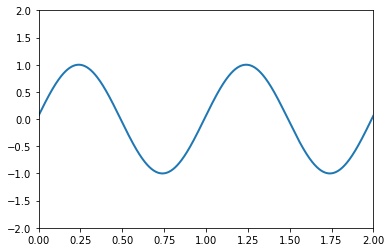

In [55]:
# Animation in Python is one thing. Animation in a Jupyter notebook is another.
# Animation in binder is yet another. Rather than try and bootstrap a lesson here
# I present a sequence of annotated steps that create an animation, save it as 
# an .mp4 file, load it and run it: In a Jupyter notebook of course. Then we
# will see how it does in binder.

# At some point in working on this I did a conda install ffmpeg. I am not clear 
#   right now on whether this was necessary or not; I suspect not.

%matplotlib inline

# With [the inline] backend activated with this line magic matplotlib command, the output 
# of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored 
# in the notebook document.

# de rigeur, commented out here as this runs at the top of the notebook
# import numpy as np
# import matplotlib.pyplot as plt

from matplotlib import animation, rc      # animation provides tools to build chart-based animations.
                                          # Each time Matplotlib loads, it defines a runtime configuration (rc) 
                                          #   containing the default styles for every plot element you create. 
                                          #   This configuration can be adjusted at any time using 
                                          #   the plt. ... matplotlibrc file, which you can read about 
                                          #   in the Matplotlib documentation.


from IPython.display import HTML, Video   # HTML is ...?...
                                          # Video is used for load/playback

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=12, blit=True)

HTML(anim.to_html5_video())

# print(anim._repr_html_() is None) will be True
# anim

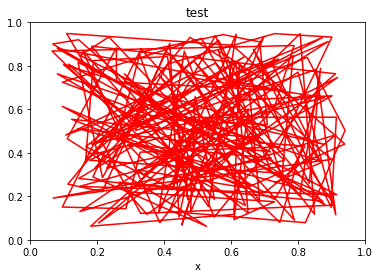

In [57]:
def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = .05 + 0.9*np.random.rand(2, 200)
l, = plt.plot([], [], 'r-')                # l, takes the 1-tuple returned by plt.plot() and grabs that first 
                                           # and only element; so it de-tuples it

plt.xlim(0, 1); plt.ylim(0, 1); plt.xlabel('x'); plt.title('test')

lines_anim = animation.FuncAnimation(fig1, update_line, 200, fargs=(data, l), interval=1, blit=True)

# fargs are additional arguments to 'update_line()' in addition to the frame number: data and line
# interval is a time gap between frames (guess is milliseconds)
# blit is the idea of modifying only pixels that change from one frame to the next

# For direct display use this: HTML(line_ani.to_html5_video())
lines_anim.save('./lines_tmp3.mp4')            # save the animation to a file
Video("./lines_tmp3.mp4")                      # One can add , embed=True

/home/ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-58-306c6a1e1e46>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))


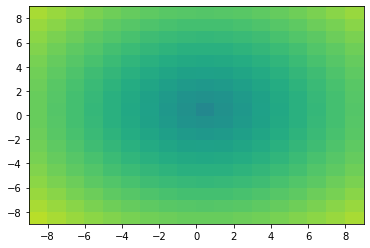

In [58]:

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
# im_ani.save('im.mp4', metadata={'artist':'Guido'})

HTML(im_ani.to_html5_video())

## Binder

* Create a binder badge in the home page `README.md` of the repository. 

```
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/<accountname>/<reponame>/HEAD)

```

* In `<repo>/binder` create `environment.yml` to match the working environment
    * For this repo as of 10/23/2021 `binder/environment.yml` was: 


```
channels:
  - conda-forge
dependencies:
  - python=3
  - numpy
  - pandas
  - matplotlib
  - netcdf4
  - xarray
  - ffmpeg
```


